# Single dimer response to a rotating magnetic field

In this notebook I am trying to figure out if I obtain the correct response to a rotating magnetic field. I will try to compare this response to the analytic expression obtain by Andrej for the critical frequency $f_c$ and the rupture frequency $f_r$. Finally, I will try to determine what are the necessary conditions for two dimers to show repulsive interactions when rotating. 

In [105]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo
import sympy as smp
import copy as cp

from IPython.display import HTML

smp.init_printing()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Angular velocity and distance functions.

This is the function we use to calculate the angular velocity. It calculates it irregardless of the distance between particles. The distance between particles should show when the system undergoes rupture. 

In [3]:
def calculate_pair_angular_velocity(trj):
    """ 
    Calculates the mean angular velocity of one particle with respect to the other in a trajectory with two particles
    """
    
    ids = trj.index.get_level_values('id').unique()
    
    if np.size(trj.index.get_level_values('id').unique())!=2:
        raise ValueError("This function only accepts two particles")
        
    idx = pd.IndexSlice
    frames = trj.index.get_level_values('frame').unique()
    time = trj.index.get_level_values('frame').unique().values*sim.run_parameters.timestep
    angle = np.empty(np.shape(time))
    
    for i,f in enumerate(frames):
        
        delta = (trj.loc[idx[f,ids[0]]].filter(('x','y','z')).values - 
                 trj.loc[idx[f,ids[1]]].filter(('x','y','z')).values)/2
        
        angle[i] =  np.arctan2(delta[0],delta[1])
    
    angle = np.unwrap(angle)
    omega = np.diff(angle)/np.diff(time)
    return np.mean(omega[time[0:-1]>0.5])

Notice that in the end we remove the first half of a second to get rid of any transient events.

## Diffusion coefficient

The diffusion coefficient reported previously [Martinez-Pedrero 2014] for these particles is $D = 0.14\frac{\mu{m}^2}{s}$
However, Andrej, in his notes, fits the critical frequency of Helena's data to the analytic expression for a dimer rotating and obtains $f_0 = 14.3 Hz$, where 

$$f_0 = \frac{3\mu_0 |\vec{m}|^2}{2\pi^2 d^5\gamma}$$

$\gamma$ is the viscous drag $\vec{m}$ is the magnetic moment, and $\mu_0$ is the permeability of free space.

The magnetic moment of a particle is given by: 

$$|\vec{m}| = \frac{V\chi{}B}{\mu}$$

then:

In [99]:
f0,mu0,m,d,gm,V,chi,B,mu,D,kbT = smp.symbols(r'f_0 \mu_0 |\vec{m}| d \gamma V \chi B \mu D k_{b}T')
T, m, A, N, s, um = smp.symbols(r'\mathrm{T} \mathrm{m} \mathrm{A} \mathrm{N} \mathrm{s} \mu{\mathrm{m}}')

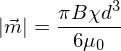

In [57]:
expr1 = smp.Eq(m,V*chi*B/mu).subs(V,smp.Rational(4,3)*smp.pi*(d/2)**3).subs(mu,mu0)
expr1

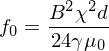

In [59]:
expr2 = smp.Eq(f0,3*mu0*m**2/(2*smp.pi**2*d**5*gm)).subs(m,expr1.rhs)
expr2

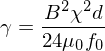

In [72]:
expr3 = smp.Eq(gm,smp.solveset(expr2,gm).args[0].args[0])
expr3

we consider 
* $\mu\approx\mu_0=4\times10^{-7}\pi \mathrm{\frac{Tm}{A}}$
* $B = 7.28\times10^{-3}\mathrm{T}$
* $\chi=0.4$
* $d=2.8\mu{m}$
and from Andrej fit,
* $f_0 = 14.3 Hz$

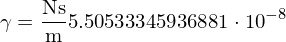

In [85]:
expr4 = expr3.subs(mu0,4e-7*smp.pi*T*m/A).\
    subs(B,7.28e-3*T).\
    subs(chi,0.4).\
    subs(d,2.8e-6*m).\
    subs(f0,14.3/s).\
    subs(T,N/A/m)

expr4.evalf()

Now from Einstein's relation:
$$ D = \frac{k_bT}{\gamma}$$

and taking 
* $k_bT = 4\times 10^{-21} \mathrm{Nm}$

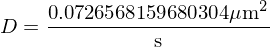

In [100]:
smp.Eq(D,kbT/gm).subs(kbT,4e-21*N*m).subs(gm,expr4.rhs).subs(m,um*1e6).evalf()

## Critical Frequency at a given height

As seen in the notebook 14, the response frequency of a single dimer for low confinement can be given by an Adler Function 

In [15]:
def rel_freq_fun(f,fc):
    rel_freq = np.empty(np.shape(f))
    rel_freq[f<=fc] = 1
    rel_freq[f>fc] = 1-np.sqrt(1-(fc/f[f>fc])**2)
    return rel_freq

In this first example we use the value of the diffusion constant given by Martinez-Pedrero (2014)
$$D = 0.14 \frac{\mu{m}^2}{s}$$

In [108]:
%%time 

radius = 1.4 #um
angle = 27 #degrees
height = 5

frequency = np.linspace(1,np.sqrt(50),10)**2
rel_freq = np.nan*np.ones(np.shape(frequency))

region = [100,100,height]

sigma = 2*radius
y = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
z = 1/2*(sigma-height)
initial_positions = np.array([[0,-y,-z],[0,y,z]])
alpha = np.arccos((height-sigma)/sigma)

for i,f in enumerate(frequency):
    sim = lmp.sim(initial_positions,
              magnitude = 7.28,
              file_name = "single_dimer_rotation",
              dir_name = "SingleD",
              radius = radius,
              diffusion = 0.14,
              frequency=f,
              susceptibility = 0.4,
              angle=angle,
              framerate=1e3,
              timestep=1e-4,
              total_time = 1,
              temperature = 300,
              stamp_time = False,
              space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

    sim.generate_scripts()
    sim.run()
    trj = sim.load(read_trj=True)
    rel_freq[i] = calculate_pair_angular_velocity(trj)/(2*np.pi*f)

Wall time: 38.8 s


In [109]:
rel_freq_diffusion1 = cp.deepcopy(rel_freq)

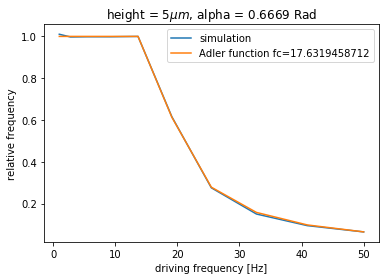

In [110]:
""" fit data then plot"""
fc = spo.curve_fit(rel_freq_fun,frequency,rel_freq)[0][0]
plt.plot(frequency,np.vstack((rel_freq,rel_freq_fun(frequency,fc))).transpose())

plt.title('height = %g$\mu{m}$, alpha = %2.4g Rad'%(height,alpha))
plt.xlabel('driving frequency [Hz]')
plt.ylabel('relative frequency')
plt.legend(['simulation','Adler function fc='+str(fc)]);

Now we try with the value of the diffusion derived from Andrej fit.

$$D = 0.073\frac{\mu{m}^2}{s}$$

In [111]:
%%time 

radius = 1.4 #um
angle = 27 #degrees
height = 5

frequency = np.linspace(1,np.sqrt(50),10)**2
rel_freq = np.nan*np.ones(np.shape(frequency))

region = [100,100,height]

sigma = 2*radius
y = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
z = 1/2*(sigma-height)
initial_positions = np.array([[0,-y,-z],[0,y,z]])
alpha = np.arccos((height-sigma)/sigma)

for i,f in enumerate(frequency):
    sim = lmp.sim(initial_positions,
              magnitude = 7.28,
              file_name = "single_dimer_rotation",
              dir_name = "SingleD",
              radius = radius,
              diffusion = 0.073,
              frequency=f,
              susceptibility = 0.4,
              angle=angle,
              framerate=1e3,
              timestep=1e-4,
              total_time = 1,
              temperature = 300,
              stamp_time = False,
              space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

    sim.generate_scripts()
    sim.run()
    trj = sim.load(read_trj=True)
    rel_freq[i] = calculate_pair_angular_velocity(trj)/(2*np.pi*f)

Wall time: 39.5 s


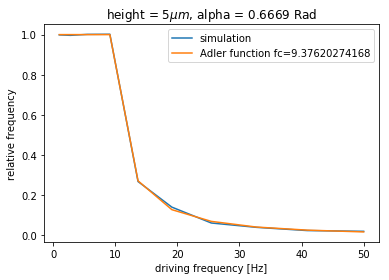

In [113]:
""" fit data then plot"""
fc = spo.curve_fit(rel_freq_fun,frequency,rel_freq)[0][0]
plt.plot(frequency,np.vstack((rel_freq,rel_freq_fun(frequency,fc))).transpose())

plt.title('height = %g$\mu{m}$, alpha = %2.4g Rad'%(height,alpha))
plt.xlabel('driving frequency [Hz]')
plt.ylabel('relative frequency')
plt.legend(['simulation','Adler function fc='+str(fc)]);

## Cutoff frequency as a function of wall separation

We remember the definition of $\alpha$ is: 

$$ \cos(\alpha) = \frac{h-\sigma}{\sigma}$$

In [139]:
%%time

alpha = np.linspace(0.2,np.pi/2,30+1)[:-1]

height = sigma*np.cos(alpha)+sigma
radius = 1.4 #um
angle = 27 #degrees
frequency = np.linspace(1,np.sqrt(144),30)**2
rel_freq = np.empty(np.shape(frequency))
timestep = np.empty(np.shape(frequency))

cutoff_frequency = np.nan*np.ones(np.shape(height))

response = []

for j,h in enumerate(height):
    
    region = [100,100,h]
    sigma = 2*radius
    y = 1/2*np.sqrt(sigma**2-(sigma-h)**2)
    z = 1/2*(sigma-h)
    initial_positions = np.array([[0,-y,-z],[0,y,z]])
    
    for i,f in enumerate(frequency):
        sim = lmp.sim(initial_positions,
                      magnitude = 7.28,
                      file_name = "single_dimer_rotation_f%g"%f,
                      dir_name = "C:/Users/aortiza/Desktop/SingleD/h_%g"%h,
                      radius = radius,
                      diffusion = 0.073,
                      frequency=f,
                      susceptibility = 0.4,
                      angle=angle,
                      framerate=1e3,
                      timestep=1e-4,
                      total_time = 1,
                      temperature = 300,
                      stamp_time = False,
                      space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

        sim.generate_scripts()
        sim.run()
        trj = sim.load(read_trj=True)
        
        last_simulated_frame = trj.index.get_level_values('frame').max()
        last_requested_frame = sim.run_parameters.total_time/sim.run_parameters.timestep
        
        while (last_simulated_frame<last_requested_frame) & (sim.run_parameters.timestep>1e-6):
            sim.run_parameters.timestep = sim.run_parameters.timestep/2
            sim.generate_scripts()
            sim.run()
            trj = sim.load(read_trj=True)
        
        timestep[i] = sim.timestep
        rel_freq[i] = calculate_pair_angular_velocity(trj)/(2*np.pi*f)
    
    res = pd.DataFrame({'response':rel_freq,'timestep':timestep},index=frequency)
    res.index.name='frequency'
    res.to_csv(path_or_buf=sim.base_name+'.dat',sep="\t")
    
    response.append(res)
    
    try:
        rel_freq_fit = rel_freq[~np.isnan(rel_freq)]
        frequency_fit = frequency[~np.isnan(rel_freq)]
        cutoff_frequency[j] = spo.curve_fit(rel_freq_fun,frequency_fit,rel_freq_fit)[0][0]
    except:
        cutoff_frequency[j]=np.nan

C:\ProgramFiles\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Wall time: 1h 43s


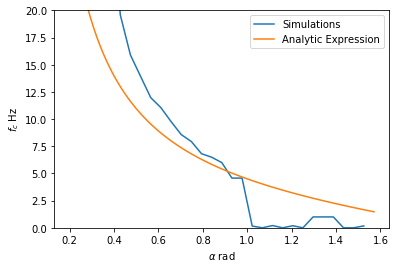

In [162]:
alpha = np.arccos((height-sigma)/sigma)
plt.plot(alpha,cutoff_frequency)

alpha_expr = np.linspace(0.2,np.pi/2,100)
theta = 27/180*np.pi
delta = np.arccos(1/4*np.sqrt((np.tan(alpha_expr)*np.tan(theta))**(-2)+8)-1/(4*np.tan(alpha_expr)*np.tan(theta)))

sa = np.sin(alpha_expr)
st = np.sin(theta)
sd = np.sin(delta)
ca = np.cos(alpha_expr)
ct = np.cos(theta)
cd = np.cos(delta)

f0 = 14.3
fc_expr = f0*st/sa*sd*(sa*st*cd+ca*ct)
plt.plot(alpha_expr,fc_expr)

plt.xlabel("$\\alpha$ rad")
plt.ylabel("$f_c$ Hz")
plt.ylim(0,20)
plt.legend(['Simulations','Analytic Expression'])

In [161]:
Data = pd.DataFrame({"height":height,"alpha":alpha,"F_c":cutoff_frequency})

Data.to_csv(path_or_buf='SingleDimerCutoffFreqencyVsHeight.dat',sep='\t',index=False)